В этом блокноте мы обсудим дискретное двумерное вейвлет преобразование (DWT), увидим, как оно может использоваться для сжатия изображений.
Для начала установим необходимую версию библиотеки и подключим то, чем будем пользоватья в дальнейшем.


In [1]:
!pip install opencv-python==4.4.0.42

In [2]:
import cv2
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib as mpl
#mpl.rcParams['figure.dpi'] = 300
import pywt
import pywt.data
import numpy as np
from math import sqrt
from PIL import Image, ImageChops, ImageOps
import pickle

**Дискретное (DWT) двумерное вейвлет-преобразование в Python** 

Вейвлет-преобразования основываются на том, что в реальных изображениях соседние пиксели практически не отличаются друг от друга. Если вместо двух соседних пикселей брать их полусумму и полуразность, то в результате мы получим два отфильтрованных изображения, из которых легко восстановить исходное. Усредняя яркость (то есть беря полусуммы), мы накладываем некий частотный фильтр. Взятие полуразностей же «выделяет» среди значений межпиксельные всплески и устраняет константную составляющую - это, в некотором смысле, эквивалентно применению низкочастотного фильтра.

Вейвлет-преобразование Хаара — это пара фильтров, разделяющих сигнал на низкочастотную и высокочастотную составляющие. В вейвлет-преобразовании Ингрид Добеши берется уже по четыре значения со смещением 2. Именно эти два преобразования и будем рассматривать.

Начнем с того, что научимся осуществлять дискретное вейвлет-преобразование средствами Python. Для начала считаем черно-белое изображение и выведем его на экран. Если исходное изображение оказывается цветным, то придется работать с каждым его каналом отдельно.


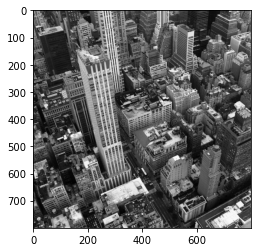

In [3]:
img = cv2.imread('new_york.jpg')
image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(image,cmap='gray');

Выполним вейвлет-преобразование Хаара с помощью функции dwt2, у которой в качестве аргументов указываем исходное изображение и название вейвлета (в нашем случае «haar»).

In [4]:
wavelet = 'haar'
c = pywt.dwt2(image,wavelet)
cA, (cH, cV, cD)= c


В результате выполнения этой функции получаем 4 набора (фильтра) (cA, (cH, cV, cD))(усредненный и 3 детальных – горизонтальный, вертикальный и диагональный). В дискретном случае фильтры задаются просто перечислением их значений (коэффициентов) в точках дискретизации.

                            -------------------
                            |        |        |   L - low
                            | cA(LL) | cH(LH) |   H - high
                            |        |        |
                            -------------------
                            |        |        |
                            | cV(HL) | cD(HH) |
                            |        |        |
                            -------------------


Выведем на экран изображения , соответсвующие каждому набору


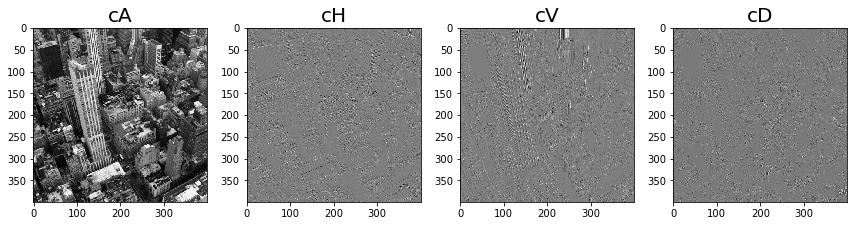

In [5]:
titles = ['cA', 'cH', 'cV', 'cD']
fig = plt.figure(figsize=(12, 3))
for i, a in enumerate([cA, cH, cV, cD]):
  ax = fig.add_subplot(1, 4, i + 1)
  ax.imshow(a, interpolation="nearest", cmap = 'gray')
  ax.set_title(titles[i], fontsize=20)
fig.tight_layout()
plt.show()


Стоит обратить внимание на размер каждого набора — это четверть от размера исходного изображения.
Видно, что последние 3 набора близки к нулю (серый цвет). Эта способность вейвлет-преобразования разреженно представлять естественные изображения является ключевой для сжатия и восстановления изображений.
Давайте проделаем еще одно вейвлет-преобразование Хаара, но уже для первого набора:


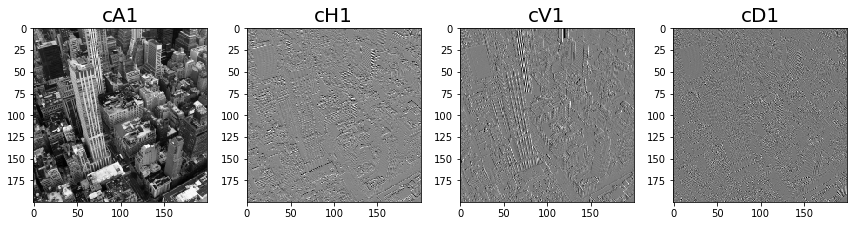

In [6]:
cA1, (cH1, cV1, cD1) = pywt.dwt2(cA,wavelet)
titles = ['cA1', 'cH1', 'cV1', 'cD1']
fig = plt.figure(figsize=(12, 3))
for i, a in enumerate([cA1, cH1, cV1, cD1]):
  ax = fig.add_subplot(1, 4, i + 1)
  ax.imshow(a, interpolation="nearest", cmap = 'gray')
  ax.set_title(titles[i], fontsize=20)
fig.tight_layout()
plt.show()

Если продолжить дальше (это можно делать рекурсивно), то

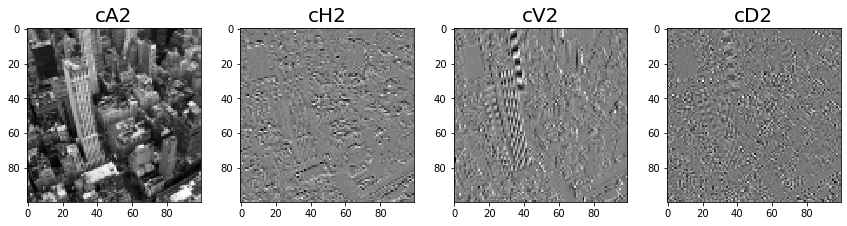

In [7]:
cA2, (cH2, cV2, cD2) = pywt.dwt2(cA1,wavelet)
titles = ['cA2', 'cH2', 'cV2', 'cD2']
fig = plt.figure(figsize=(12, 3))
for i, a in enumerate([cA2, cH2, cV2, cD2]):
  ax = fig.add_subplot(1, 4, i + 1)
  ax.imshow(a, interpolation="nearest", cmap = 'gray')
  ax.set_title(titles[i], fontsize=20)
fig.tight_layout()
plt.show()

Качество первого набора начинает ухудшаться.
Давайте попробуем взять исходное изображение и применить к нему функцию resize, чтобы сравнить с набором cA2.


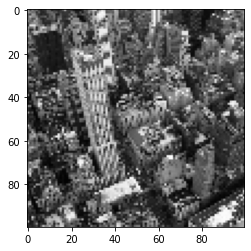

In [8]:
image_resized = cv2.resize(image, cA2.shape)  # уменьшаем до размеров набора сА2 
plt.imshow(image_resized,cmap='gray');
plt.show()

Разница заметна – набор сА2 даёт лучшую картину.

Теперь попробуем восстановить изначальную картину – сделаем обратное вейвлет-преобразование Хаара. Для этого будем использовать функцию idwt2, и наши первые полученные наборы С (абсолютно аналогично можно сделать для всех других).

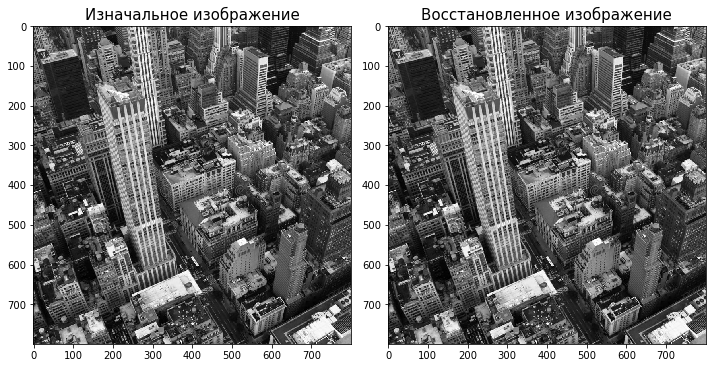

In [9]:
w, h = image.shape  # размер исходного изображения
c_inverse = pywt.idwt2((c),wavelet)[:h,:w]
titles = ['Изначальное изображение', 'Восстановленное изображение']
fig = plt.figure(figsize=(10, 6))
for i, a in enumerate([image,c_inverse]):
  ax = fig.add_subplot(1, 2, i + 1)
  ax.imshow(a, interpolation="nearest", cmap = 'gray')
  ax.set_title(titles[i], fontsize=15)
fig.tight_layout()
plt.show()


Отличий невооруженным взглядом увидеть не удается. Но и выгода преобразования пока сомнительна.

Теперь попробуем «удалить лишнее» - обнулим близкие к единице коэффициенты в наборах – осуществим квантование.  Действительно, построим графики первой строки для всех элементов набора (cA, cH, cV, cD)

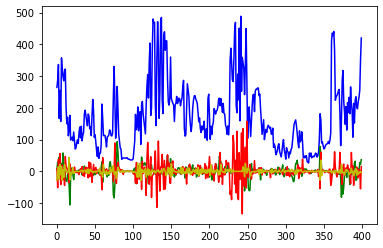

In [10]:
x = [i for i in range(len(c[0]))]   # координата Х для сА
y = [c[0][0][i] for i in range(len(c[0]))]  # координата Y для сА (нулевая строка)
x1 = [i for i in range(len(c[1][0]))]   # координата Х для сH
y1 = [c[1][0][0][i] for i in range(len(c[1][0]))] # координата Y для сH (нулевая строка)
x2 = [i for i in range(len(c[1][1]))]  # координата Х для сV
y2 = [c[1][1][0][i] for i in range(len(c[1][1]))]  # координата Y для сV (нулевая строка)
x3 = [i for i in range(len(c[1][2]))]  # координата Х для сD
y3 = [c[1][2][0][i] for i in range(len(c[1][2]))]  # координата Y для сD (нулевая строка)
plt.plot(x,y,'b',x1,y1,'g',x2,y2,'r',x3,y3,'y') # cA - синий, сH -зеленый, сV - красный сD - желтый


Очевидно, что количество «маленьких» коэффициентов в наборах cH, cV, cD велико и их обнуление не будет критичным. 

Количество нулей в наборе можно получить следующим образом:

In [11]:
print('Количество нулей в наборе cA =',sum(sum(c[0][m] == 0) for m in range(len(c[0]))))
print('Количество нулей в наборе cH =',sum(sum(c[1][0][m] == 0) for m in range(len(c[1][0]))))
print('Количество нулей в наборе cV =',sum(sum(c[1][1][m] == 0) for m in range(len(c[1][1]))))
print('Количество нулей в наборе cD =',sum(sum(c[1][2][m] == 0) for m in range(len(c[1][2]))))


Количество нулей в наборе cA = 0
Количество нулей в наборе cH = 3104
Количество нулей в наборе cV = 4048
Количество нулей в наборе cD = 6564


Всего нулей во всех наборах можно вычислить так:

In [12]:
print((sum(sum(sum(c[1][m][n] == 0) for n in range(len(c[1][0]))) for m in range(len(c[1])))) + sum(sum(c[0][m] == 0) for m in range(len(c[0]))))

13716


Для начала возьмем некоторое значение (threshold) и заменим меньшие по модулю коэффициены на ноль. Выведем  количество нулей после изменений.

Сначала для threshold = 10

In [13]:
threshold = 10
h1 = cA.shape[0] # у нас все наборы имеют вид квадратной матрицы
for i in range(h1):
      c[0][i][np.abs(c[0][i])<threshold] = 0.0 # для cA
      for j in range(len(c[1])):
         c[1][j][i][np.abs(c[1][j][i])<threshold] = 0.0  # для cH,cV,cD
print('Количество нулей =',(sum(sum(sum(c[1][m][n] == 0) for n in range(h1)) for m in range(len(c[1])))) + sum(sum(c[0][m] == 0) for m in range(h1)))


Количество нулей = 306542


Итого мы обнулили 306542 – 13716 = 292826 коэффициентов. Повторя эти манипуляции, можно увидеть, что для второго вейвлет-преобразование Хаара количество нулей увеличится и т.д.

Выполним обратное преобразование  (уже с новыми коеффициентами) и сравним с исходным изображением (код  см выше)

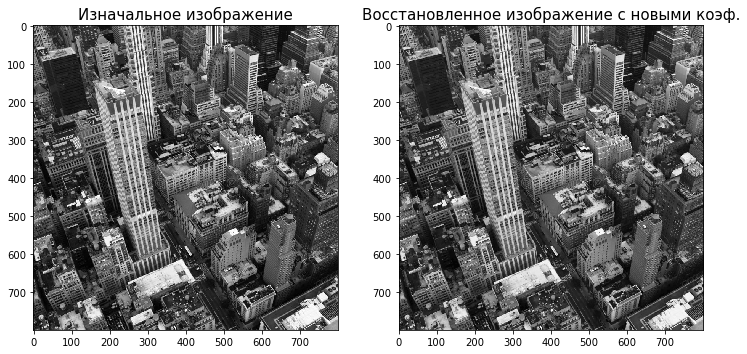

In [14]:
c_inverse1 = pywt.idwt2((c),wavelet)[:h,:w]  # коэф. с обнулены в предыдущем строке
titles1 = ['Изначальное изображение', 'Восстановленное изображение c новыми коэф.']
fig1 = plt.figure(figsize=(12, 6))
for i, a in enumerate([image,c_inverse1]):
  ax = fig1.add_subplot(1, 2, i + 1)
  ax.imshow(a, interpolation="nearest", cmap = 'gray')
  ax.set_title(titles1[i], fontsize=15)
fig.tight_layout()
plt.show()

Попробуем с threshold  = 100:

Количество нулей = 525452


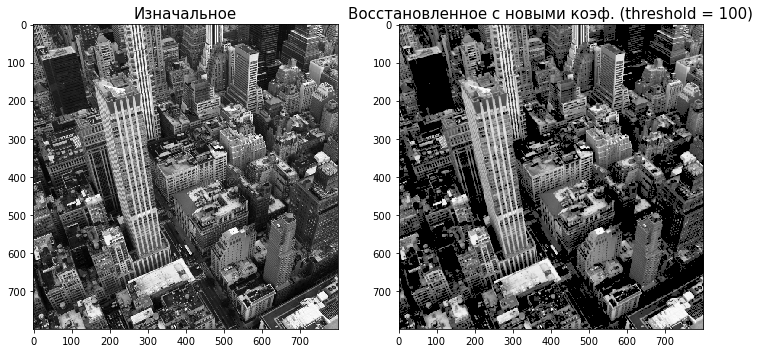

In [15]:
threshold = 100
h1 = cA.shape[0] # у нас все наборы имеют вид квадратной матрицы
for i in range(h1):
      c[0][i][np.abs(c[0][i])<threshold] = 0.0 # для cA
      for j in range(len(c[1])):
         c[1][j][i][np.abs(c[1][j][i])<threshold] = 0.0  # для cH,cV,cD
print('Количество нулей =',(sum(sum(sum(c[1][m][n] == 0) for n in range(h1)) for m in range(len(c[1])))) + sum(sum(c[0][m] == 0) for m in range(h1)))
c_inverse1 = pywt.idwt2((c),wavelet)[:h,:w]  # коэф. с обнулены в предыдущем строке
titles1 = ['Изначальное', 'Восстановленное c новыми коэф. (threshold = 100)']
fig1 = plt.figure(figsize=(12, 6))
for i, a in enumerate([image,c_inverse1]):
  ax = fig1.add_subplot(1, 2, i + 1)
  ax.imshow(a, interpolation="nearest", cmap = 'gray')
  ax.set_title(titles1[i], fontsize=15)
fig.tight_layout()
plt.show()

Видно, что темно-серые участки стали практически черными. Других же отличий невооруженным глазом практически не видно.

Сравним среднее значение пикселей на обоих изображенияж:

In [16]:
print('Среднее значение пикселя для исходного =',image.mean())
print('Среднее значение пикселя для восстановленного =',c_inverse1.mean())

Среднее значение пикселя для исходного = 89.3980640625
Среднее значение пикселя для восстановленного = 80.33412343750001


А теперь выведем отличия в виде картинки с помощью функции ImageChops.difference. Но для этого надо сохранить восстановленное изображение:

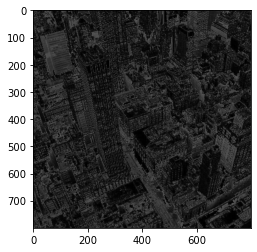

In [17]:
cv2.imwrite('test_'+wavelet+'.jpg',c_inverse1)
image2 = cv2.imread('test_'+wavelet+'.jpg')  # Прочитаем картинку
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)  # Переведем в черно-белый формат 
img1=Image.open('new_york.jpg') # открываем исходное
img2=Image.open('test_'+wavelet+'.jpg') # открываем восстановленное
result = ImageChops.difference(img1, img2)
result.show()
plt.imshow(result,cmap='gray');



Мы использовали вейвлет-преобразование Хаара и самый примитивный способ квантования.
Можно посмотреть насколько улучшатся (и улучшатся ли) результаты, если использовать вейвлет-преобразование Добеши (вейвлет DВ4).

В вейвлет-преобразовании  DВ4 фильтруется и квадратичная составляющая (помимо линейной, как в вейвлете Хаара). Для  вейвлет-преобразования  DВ4 будем использовать все тоже самое с единственным исключением: в функциях dwt2 и idwt2 вместо ‘haar’ надо писать ‘db4’ (Daubechies). В нашем случае присваиваем wavelet значение 'db4'. Берем такую же исходную картинку, применяем к ней вейвлет-преобразование  DВ4, получаем наборы, считаем в них количество нулей, обнуляем те, которые меньше threshold = 100, считаем количество нулей, делаем обратное вейвлет-преобразование  DВ4 на новых (обнуленных) наборах, сравниваем полученные результаты с аналогичными для вейвлет-преобразования Хаара




Количество нулей до квантования (DB4) = 0
Количество нулей после квантования (DB4) = 535473


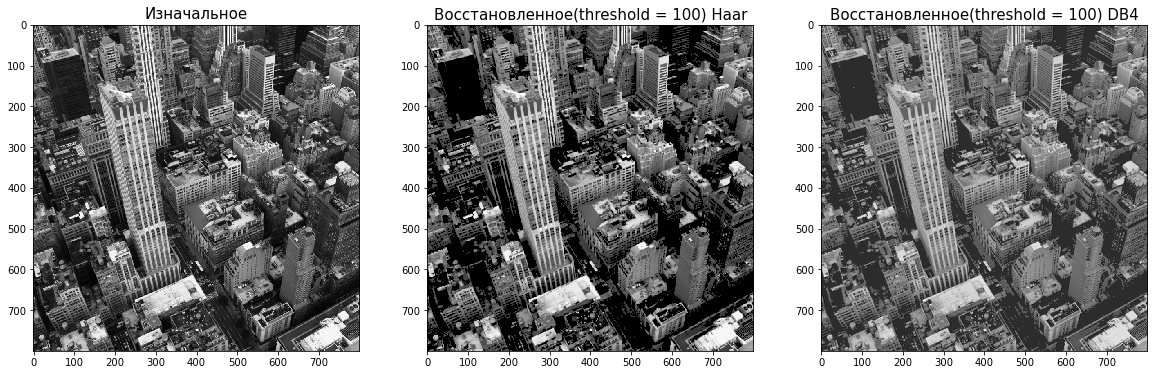

In [18]:
wavelet = 'db4'
c_new = pywt.dwt2(image,wavelet)
cA_new, (cH_new, cV_new, cD_new)= c_new
print('Количество нулей до квантования (DB4) =',(sum(sum(sum(c_new[1][m][n] == 0) for n in range(h1)) for m in range(len(c_new[1])))) + sum(sum(c_new[0][m] == 0) for m in range(h1)))
threshold = 100
h1 = cA_new.shape[0] # у нас все наборы имеют вид квадратной матрицы
for i in range(h1):
      c_new[0][i][np.abs(c_new[0][i])<threshold] = 0.0 # для cA
      for j in range(len(c_new[1])):
         c_new[1][j][i][np.abs(c_new[1][j][i])<threshold] = 0.0  # для cH,cV,cD
print('Количество нулей после квантования (DB4) =',(sum(sum(sum(c_new[1][m][n] == 0) for n in range(h1)) for m in range(len(c_new[1])))) + sum(sum(c_new[0][m] == 0) for m in range(h1)))
c_inverse_new = pywt.idwt2((c_new),wavelet)[:h,:w]  # коэф. с обнулены в предыдущем строке
titles1 = ['Изначальное', 'Восстановленное(threshold = 100) Haar', 'Восстановленное(threshold = 100) DB4']
fig1 = plt.figure(figsize=(20, 6))
for i, a in enumerate([image,c_inverse1,c_inverse_new]):
  ax = fig1.add_subplot(1, 3, i + 1)
  ax.imshow(a, interpolation="nearest", cmap = 'gray')
  ax.set_title(titles1[i], fontsize=15)
fig.tight_layout()
plt.show()

Покажем отличия от исходного:

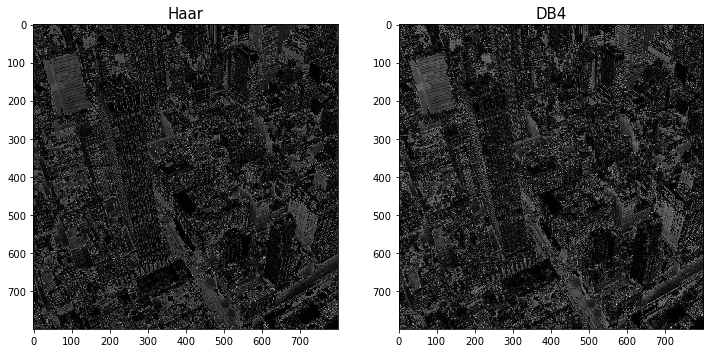

In [19]:
cv2.imwrite('test_'+wavelet+'.jpg',c_inverse_new)
image2 = cv2.imread('test_'+wavelet+'.jpg')  # Прочитаем картинку
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)  # Переведем в черно-белый формат 
img1=Image.open('new_york.jpg') # открываем исходное
img2=Image.open('test_'+wavelet+'.jpg') # открываем восстановленное
result_new = ImageChops.difference(img1, img2)
titles1 = ['Haar', 'DB4']
fig1 = plt.figure(figsize=(12, 6))
for i, a in enumerate([result, result_new]):
  ax = fig1.add_subplot(1, 2, i + 1)
  ax.imshow(a, interpolation="nearest", cmap = 'gray')
  ax.set_title(titles1[i], fontsize=15)
fig.tight_layout()
plt.show()


В итоге мы увидели следующее:

Вейвлет-преобразование работает лучше стандартного RESIZE;

Количество нулей позволяет в дальнейшем сжимать файлы лучше.
Действительно, каждое целое значение занимает 1 байт, вещественное - 8 байт, размер изображения 800Х800. Для исходного изображения (целые числа) - около 0.6 мегабайт, при этом стандартыми архиваторами (например,ZIP) его можно сжать на 5%. Если взять восстановленное изображение, грубо преобразовать к целочисленным значениям и заархивировать, то размер файла уменьшится почти на 70%!

Конечно, мы рассмотрели только "верхушку айсберга", используя самый примитивный способ квантования, грубое преобразование файлов и т.д. и т.п. Но всегда нужно с чего-то начинать! Удачи :)